# PALM quick dev

In [1]:
%matplotlib inline
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2
from peaks.peakfinder import PeakFinder
import skimage.external.tifffile as tif
from matplotlib.colors import LogNorm, PowerNorm

## Setup

First we need to find the files, check the data and check the fitting algorithm

In [2]:
# find files, all on disk thankfully
files_to_process = sorted(glob.glob("Raw Data for Slab0/*.tif"))
files_to_process[::100]

['Raw Data for Slab0\\3DPALM_532nma_Iter_000_000_ch0_CAM1_stack0000_532nm_0000000msec_0003931739msecAbs_000x_000y_000z_0000t.tif',
 'Raw Data for Slab0\\3DPALM_532nma_Iter_100_000_ch0_CAM1_stack0000_532nm_0000000msec_0030206706msecAbs_000x_000y_000z_0100t.tif',
 'Raw Data for Slab0\\3DPALM_532nma_Iter_200_000_ch0_CAM1_stack0000_532nm_0000000msec_0056495843msecAbs_000x_000y_000z_0200t.tif',
 'Raw Data for Slab0\\3DPALM_532nma_Iter_300_000_ch0_CAM1_stack0000_532nm_0000000msec_0082797772msecAbs_000x_000y_000z_0300t.tif',
 'Raw Data for Slab0\\3DPALM_532nma_Iter_400_000_ch0_CAM1_stack0000_532nm_0000000msec_0109219064msecAbs_000x_000y_000z_0400t.tif',
 'Raw Data for Slab0\\3DPALM_532nma_Iter_500_000_ch0_CAM1_stack0000_532nm_0000000msec_0135630201msecAbs_000x_000y_000z_0500t.tif',
 'Raw Data for Slab0\\3DPALM_532nma_Iter_600_000_ch0_CAM1_stack0000_532nm_0000000msec_0162060612msecAbs_000x_000y_000z_0600t.tif',
 'Raw Data for Slab0\\3DPALM_532nma_Iter_700_000_ch0_CAM1_stack0000_532nm_0000000ms

In [3]:
# grab a test stack
test_stack = tif.imread(files_to_process[350])

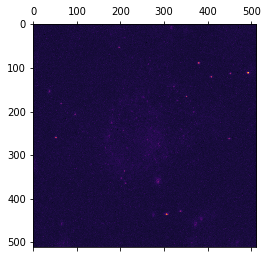

In [4]:
# plot a frame
plt.matshow(test_stack[0], cmap="inferno")

In [5]:
# try a fit
test_pf = PeakFinder(test_stack[0], 1.4, 15)
# test_pf.thresh = 10
# test_pf.find_blobs(min_sigma=1.0, max_sigma=2.0)
test_pf.find_blobs()
test_pf.remove_edge_blobs(10)
%timeit test_pf.fit_blobs(11, quiet=True, fittype="ls")
%timeit test_pf.fit_blobs(11, quiet=True, fittype="mle")

132 ms ± 1.37 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
223 ms ± 3.67 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


52


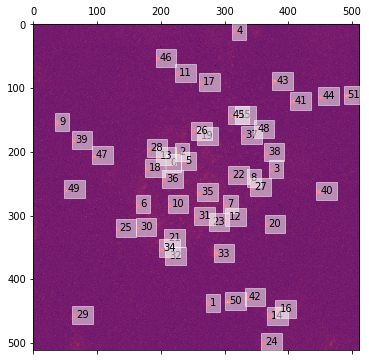

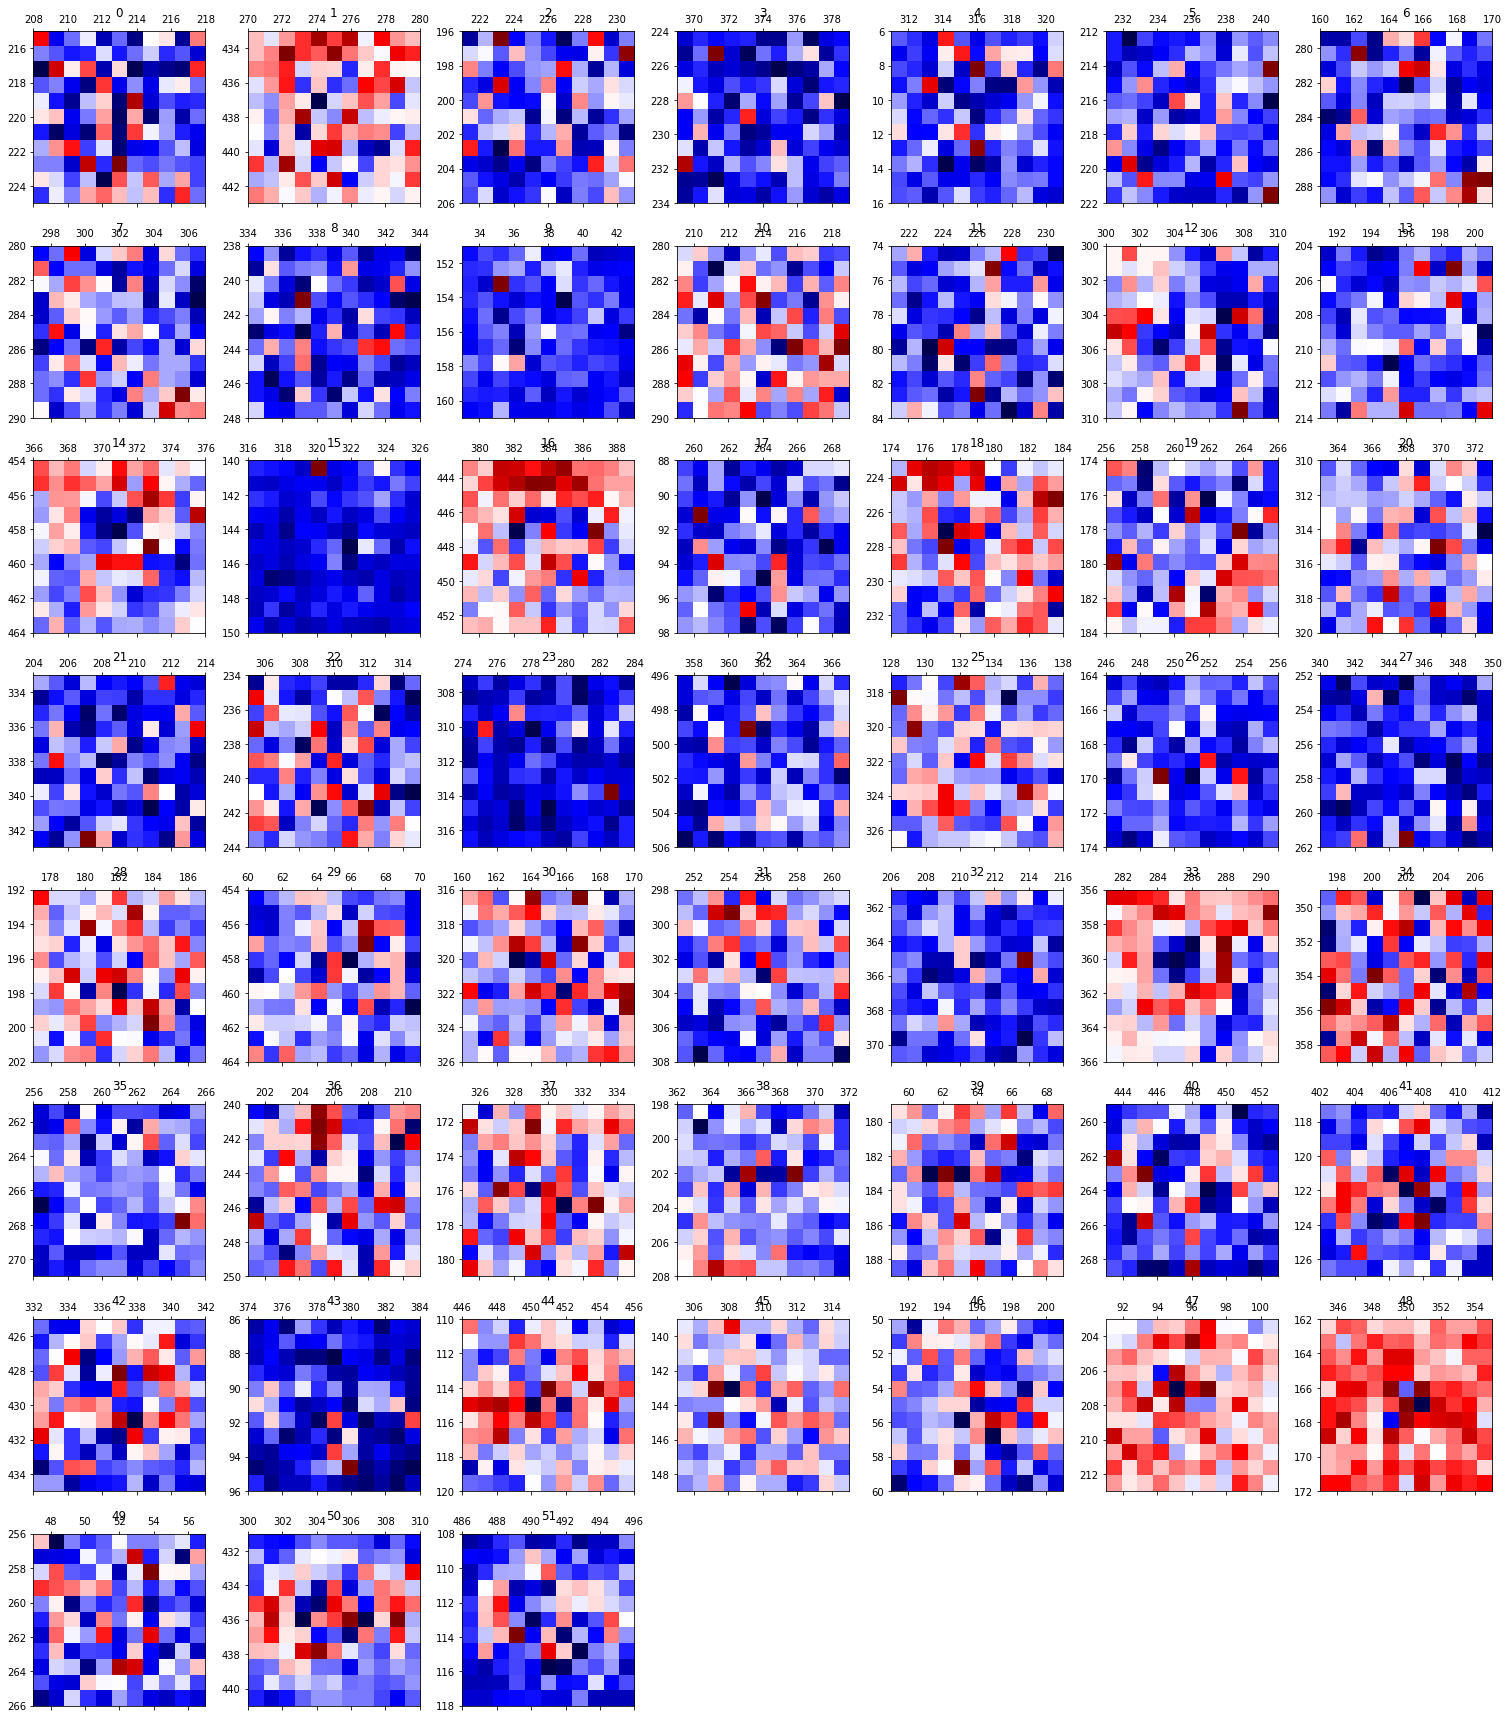

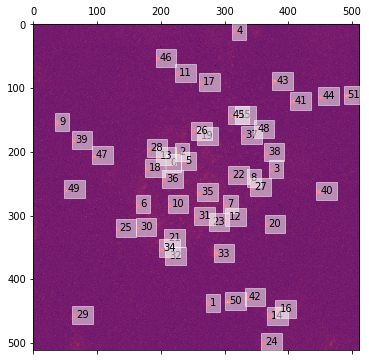

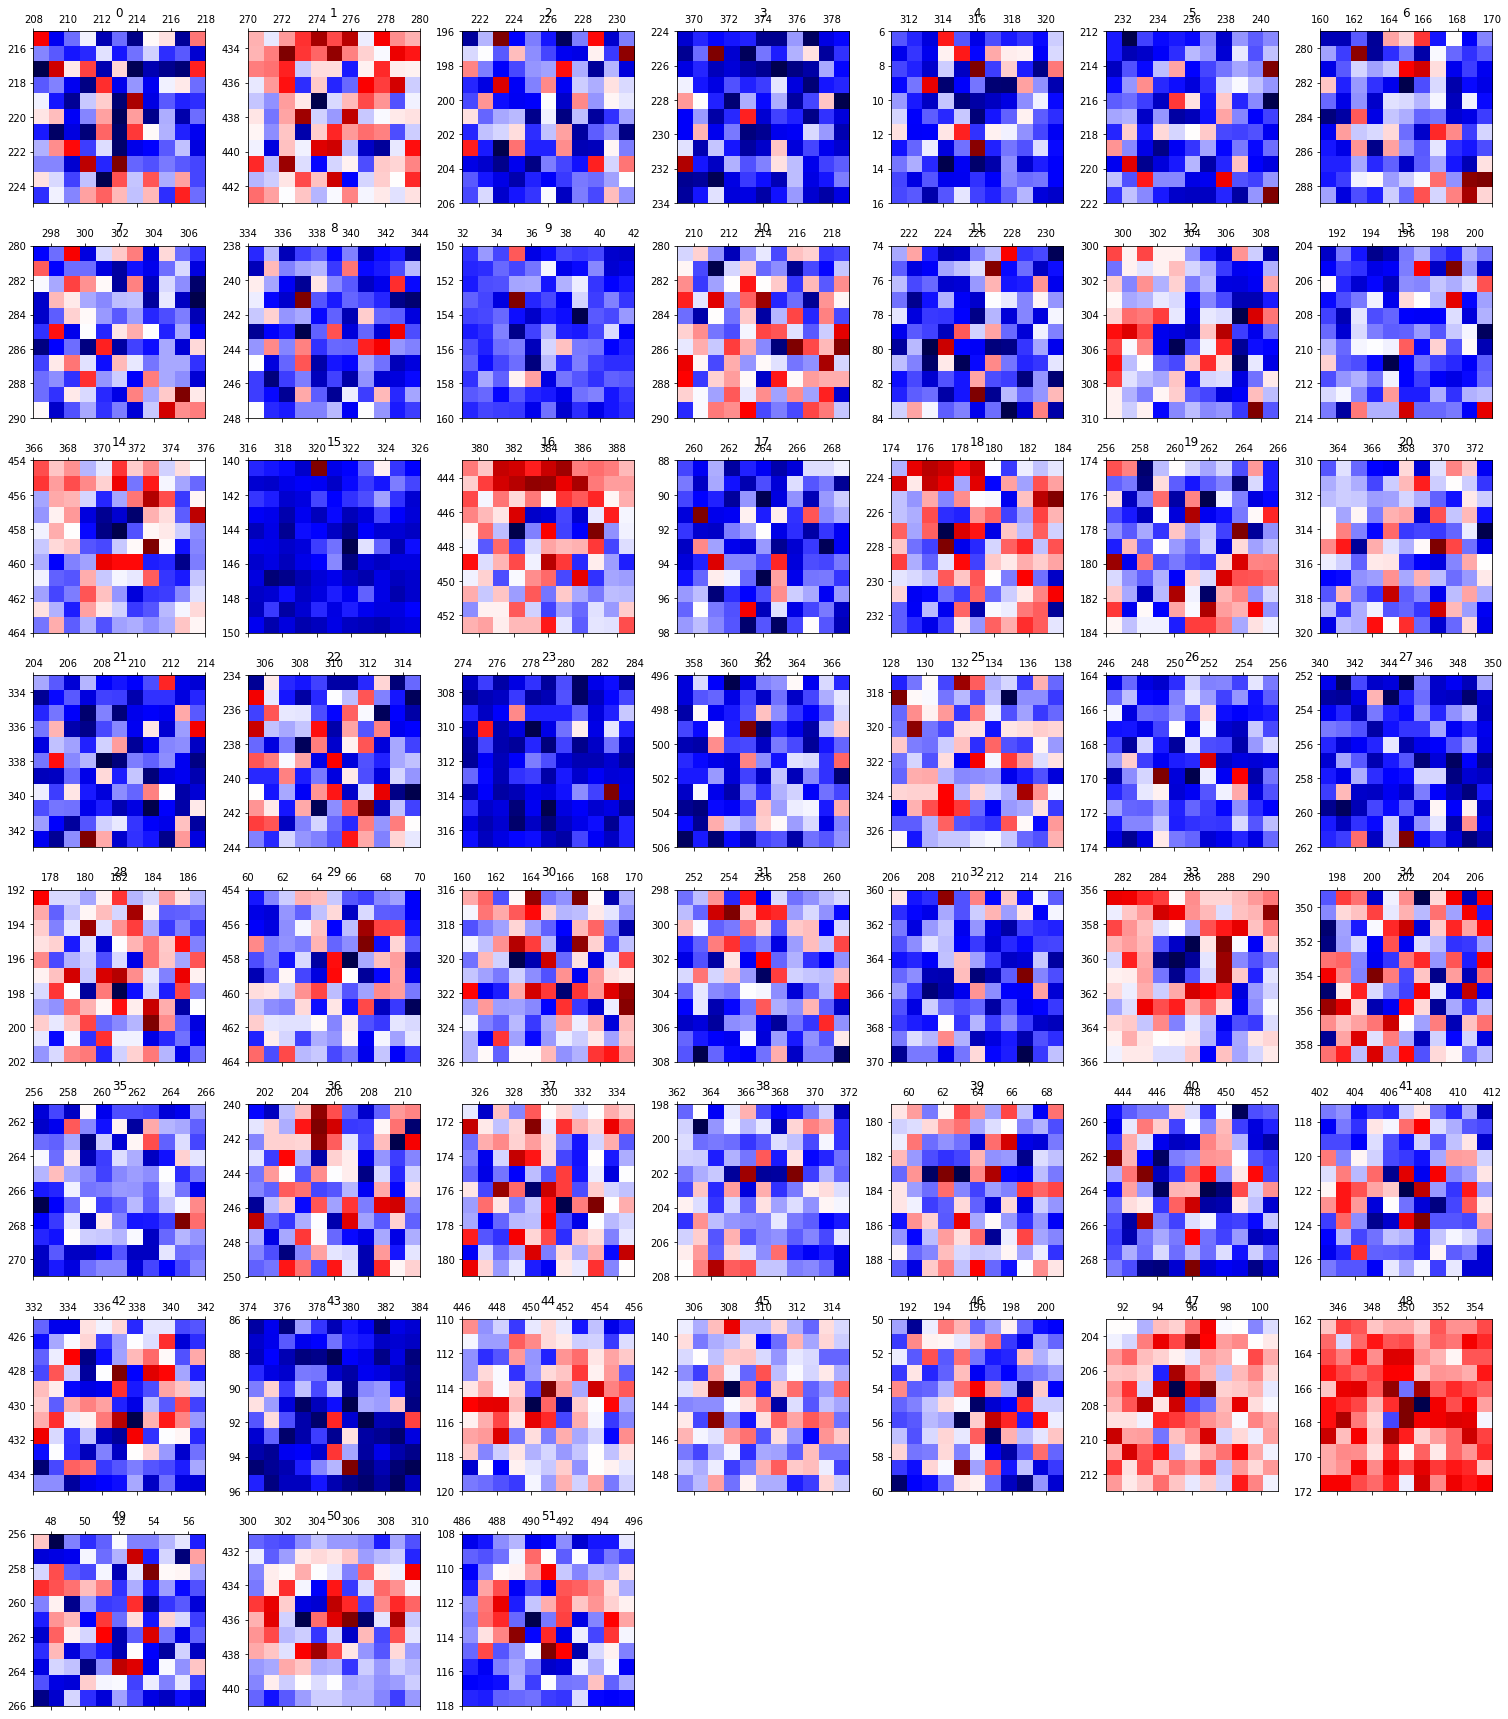

In [6]:
# check the fit
print(len(test_pf.blobs))
test_pf.fit_blobs(9, quiet=True, fittype="ls")
test_pf.plot_blobs(cmap="inferno", norm=PowerNorm(0.5))
test_pf.plot_fits(11, cmap="seismic", residuals=True);
ls_df = test_pf.fits

test_pf.fit_blobs(9, quiet=True, fittype="mle")
test_pf.plot_blobs(cmap="inferno", norm=PowerNorm(0.5))
test_pf.plot_fits(11, cmap="seismic", residuals=True);
mle_df = test_pf.fits

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000029C8A819B38>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x0000029C909D4780>]], dtype=object)

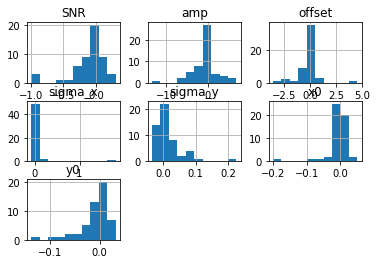

In [7]:
(mle_df - ls_df)[["SNR", "amp", "offset", "x0","y0","sigma_x", "sigma_y"]].hist()

In [8]:
# get multiprocessing support
import dask
import dask.array as da
import dask.dataframe as dd
from dask.diagnostics import ProgressBar
import dask.multiprocessing

# Lazy functions for raw data handling
lazy_imread = dask.delayed(tif.imread, pure=True)

def make_lazy_data(paths):
    """Make a lazy data array from a set of paths to data

    Assumes all data is of same shape and type."""
    lazy_data = [lazy_imread(path) for path in paths]
    # read first image for shape
    sample = tif.imread(paths[0])
    data = [da.from_delayed(ld, shape=sample.shape, dtype=sample.dtype) for ld in lazy_data]
    data_array = da.concatenate(data)
    return data_array

In [9]:
all_frames = make_lazy_data(files_to_process)

In [10]:
all_frames

dask.array<concatenate, shape=(190750, 512, 512), dtype=uint16, chunksize=(250, 512, 512)>

In [11]:
def fit_frame(data, frame, fit_width=11, bg=15, fittype="ls"):
    """Fit a single frame of data
    
    Parameters
    ----------
    data : ndarray (2D)
        the data to find and fit peaks
    frame"""
    pf = PeakFinder(data, 1.4, bg)
#     test_pf.thresh = 10
    pf.find_blobs()
    if len(pf.blobs):
        pf.blobs = pf.blobs[:100]
    pf.remove_edge_blobs(10)
    pf_fits = pf.fit_blobs(fit_width, fittype=fittype, quiet=True)
    pf_fits["frame"]=frame
    return pf_fits

def fit_blocks(block, offset, fittype="ls"):
    # turn delayed into data
    # sometimes actual array is passed, not sure why, something do do with 
    try:
        data = block.compute()
    except AttributeError:
        data = block
    j = len(data) * offset
    df = pd.concat([fit_frame(d, i + j, fittype=fittype) for i, d in enumerate(data)])
    return df

fit_blocks_delayed = dask.delayed(pure=True)(fit_blocks)

In [12]:
blocks_delayed = dask.delayed([fit_blocks_delayed(d, i, "mle") for i, d in enumerate(all_frames.to_delayed().squeeze())])

In [13]:
with ProgressBar():
    blocks_delayed_df = pd.concat(blocks_delayed.compute(get=dask.multiprocessing.get))
blocks_delayed_df.to_hdf("Localizations/Raw_MLE_wbg2.h5", "raw_fits")

[########################################] | 100% Completed |  1hr 16min 12.2s


# With background subtraction

In [12]:
bg = tif.imread("Camera Calibration/dark_wo_1st_512x512_mean.tif")

In [15]:
bg.shape

(512, 512)

In [13]:
all_frames_nb = all_frames - bg
all_frames_nb

dask.array<sub, shape=(190750, 512, 512), dtype=float32, chunksize=(250, 512, 512)>

In [14]:
all_frames_nb_max = da.maximum(all_frames_nb, 0)
all_frames_nb_max

dask.array<maximum, shape=(190750, 512, 512), dtype=float32, chunksize=(250, 512, 512)>

In [18]:
test_frame_nb = all_frames_nb[0].compute()
test_frame_nb_max = all_frames_nb_max[0].compute()

-9.4514084

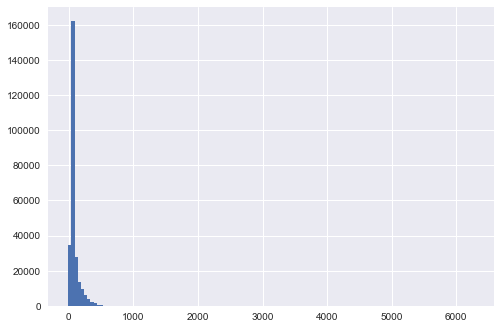

In [19]:
fig, ax = plt.subplots()
ax.hist(test_frame_nb.ravel(), bins=128)
test_frame_nb.min()

0.0

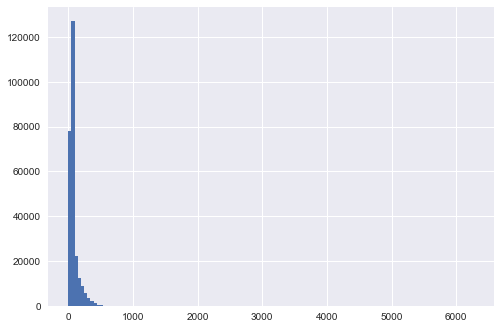

In [20]:
fig, ax = plt.subplots()
ax.hist(test_frame_nb_max.ravel(), bins=128)
test_frame_nb_max.min()

In [21]:
# mle fitting with no background
blocks_delayed = dask.delayed([fit_blocks_delayed(d, i, "mle") for i, d in enumerate(all_frames_nb.to_delayed().squeeze())])
with ProgressBar():
    blocks_delayed_df = pd.concat(blocks_delayed.compute(get=dask.multiprocessing.get))
blocks_delayed_df.to_hdf("Localizations/Raw_MLE_nb2.h5", "raw_fits")

[########################################] | 100% Completed |  1hr 28min 36.4s


In [38]:
# ls fitting with no background
blocks_delayed = dask.delayed([fit_blocks_delayed(d, i, "ls") for i, d in enumerate(all_frames_nb.to_delayed().squeeze())])
with ProgressBar():
    blocks_delayed_df = pd.concat(blocks_delayed.compute(get=dask.multiprocessing.get))
blocks_delayed_df.to_hdf("Raw_LS_nb2.h5", "raw_fits")

[########################################] | 100% Completed | 52min  3.4s


## Taking into account variance for MLE

Following this article http://www.biorxiv.org/content/early/2017/08/08/172643

In [39]:
var = tif.imread("Camera Calibration/dark_wo_1st_512x512_var.tif")

In [40]:
all_frames_nb_var_max = da.maximum(all_frames - bg + var, 0)
all_frames_nb_var_max

dask.array<maximum, shape=(190750, 512, 512), dtype=float32, chunksize=(250, 512, 512)>

In [41]:
# mle fitting with no background
blocks_delayed = dask.delayed([fit_blocks_delayed(d, i, "mle") for i, d in enumerate(all_frames_nb_var_max.to_delayed().squeeze())])
with ProgressBar():
    blocks_delayed_df = pd.concat(blocks_delayed.compute(get=dask.multiprocessing.get))
blocks_delayed_df.to_hdf("Raw_MLE_nb_var2.h5", "raw_fits")

[########################################] | 100% Completed |  2hr 30min 56.7s


In [42]:
blocks_delayed_df.infoo()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13752846 entries, 0 to 91
Data columns (total 15 columns):
SNR          float64
amp          float64
amp_e        float64
noise        float64
offset       float64
offset_e     float64
sigma_x      float64
sigma_x_e    float64
sigma_y      float64
sigma_y_e    float64
x0           float64
x0_e         float64
y0           float64
y0_e         float64
frame        int64
dtypes: float64(14), int64(1)
memory usage: 2.0 GB


# With z now

In [17]:
zcalib = pd.read_hdf("z_calib3_weighted.h5", "psf_nb/ls/win19").dropna()

In [18]:
# try a fit
test_pf = PeakFinder(test_stack[0], 1.4, 15)
# test_pf.thresh = 10
# test_pf.find_blobs(min_sigma=1.0, max_sigma=2.0)
test_pf.find_blobs()
test_pf.remove_edge_blobs(10)
%timeit test_pf.fit_blobs(11, quiet=True, fittype="ls", poly_coefs_df=zcalib)
%timeit test_pf.fit_blobs(11, quiet=True, fittype="mle", poly_coefs_df=zcalib)

468 ms ± 93 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.24 s ± 160 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [19]:
def fit_frame(data, frame, fit_width=11, bg=15, zcalib=None, fittype="ls"):
    """Fit a single frame of data
    
    Parameters
    ----------
    data : ndarray (2D)
        the data to find and fit peaks
    frame"""
    pf = PeakFinder(data, 1.4, bg)
#     test_pf.thresh = 10
    pf.find_blobs()
    if len(pf.blobs):
        pf.blobs = pf.blobs[:100]
    pf.remove_edge_blobs(10)
    pf_fits = pf.fit_blobs(width=fit_width, poly_coefs_df=zcalib, fittype=fittype, quiet=True)
    pf_fits["frame"]=frame
    return pf_fits

def fit_blocks(block, offset, zcalib=None, fittype="ls"):
    # turn delayed into data
    # sometimes actual array is passed, not sure why, something do do with 
    try:
        data = block.compute()
    except AttributeError:
        data = block
    j = len(data) * offset
    df = pd.concat([fit_frame(d, i + j, zcalib=zcalib, fittype=fittype) for i, d in enumerate(data)])
    return df

fit_blocks_delayed = dask.delayed(pure=True)(fit_blocks)

In [20]:
# mle fitting with no background
blocks_delayed = dask.delayed([fit_blocks_delayed(d, i, zcalib=zcalib, fittype="mle") for i, d in enumerate(all_frames_nb.to_delayed().squeeze())])
with ProgressBar():
    blocks_delayed_df = pd.concat(blocks_delayed.compute(get=dask.multiprocessing.get))
blocks_delayed_df.to_hdf("Localizations/Raw_MLE_nb_z3.h5", "raw_fits")

[########################################] | 100% Completed |  7hr  8min 45.2s


In [21]:
# mle fitting with no background
blocks_delayed = dask.delayed([fit_blocks_delayed(d, i, zcalib=zcalib, fittype="ls") for i, d in enumerate(all_frames_nb.to_delayed().squeeze())])
with ProgressBar():
    blocks_delayed_df = pd.concat(blocks_delayed.compute(get=dask.multiprocessing.get))
blocks_delayed_df.to_hdf("Localizations/Raw_LS_nb_z3.h5", "raw_fits")

[########################################] | 100% Completed |  1hr 21min  2.0s


In [27]:
import numpy.linalg as la

In [ ]:
la.LinAlgError